# Data Cleaning  

This notebook builds on our exploratory analysis and prepares the data for a Machine Learning algorithm. We will develop a preprocessing pipeline that does the following: 

1. Deals with missing values
2. adds useful attributes
3. Encodes any non-numerical data
4. Rescales our features to an appropriate range and variance for our algorithm

In [1]:
# graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# data tools
import pandas as pd
import numpy as np

In [2]:
# import our stratified training set from the ExploratoryAnalysis notebook
housing_train = pd.read_pickle("StratifiedTrainingSet.pkl")

# we will need to clean our numerical and categorical attributes seperately
# also the transformers expect numpy arrays, so seperate the labels and data
housing_train_num = housing_train.drop(columns=["ocean_proximity"]).to_numpy()
num_attribs = list(housing_train.columns[:-1])
housing_train_cat = housing_train["ocean_proximity"].to_numpy().reshape(-1,1)
cat_attribs = housing_train.columns[-1]

In [3]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


# Adding Attributes  
As discussed in the exploratory analysis notebook, we combined some of our attributes to create new ones that are more relevant to predicting the median house price. This will be the first step in our data cleaning pipeline.  

We are purposely taking this step before taking care of our missing values. This is because we will be replacing null values with the median value for that attribute, and we believe that this would introduce more error if we were to make these calculations with our dummy values. For example, the total_bedrooms attribute has a large range of values but is highly correlated with total_rooms. If we calculate bedrooms_per_room with a dummy value that is way off the true value, that could easily produce an exetreme outlier. Better to leave some null values in bedrooms_per_room and then impute that seperately.

In [4]:
# create a transformer class we can use to add our new attributes
from sklearn.base import BaseEstimator, TransformerMixin

# store the column indices we will use to make new attributes
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# note: do not add *args or **kwargs for BaseEstimator, this allows us to use get_params and set_params
# TransformerMixin will automatically allow us to call fit_transform() if we define fit() and transform()
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self # nothing else to do
    def transform(self, X):
        """
        Since this is the first transformation in our pipeline, we should expect
        a pandas DataFrame for X
        
        returns a numpy array
        """
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        
        return np.c_[X, rooms_per_household, bedrooms_per_room, population_per_household]

# note: we will have to add these column labels to our final prepared data set
combined_cols = ["rooms_per_household","bedrooms_per_room","population_per_household"]

In [5]:
# example use of above class
combiner = CombinedAttributesAdder()
combiner.transform(housing_train_num)

array([[-121.89      ,   37.29      ,   38.        , ...,    4.62536873,
           0.22385204,    2.09439528],
       [-121.93      ,   37.05      ,   14.        , ...,    6.00884956,
           0.15905744,    2.7079646 ],
       [-117.2       ,   32.77      ,   31.        , ...,    4.22510823,
           0.24129098,    2.02597403],
       ...,
       [-116.4       ,   34.09      ,    9.        , ...,    6.34640523,
           0.17960865,    2.74248366],
       [-118.01      ,   33.82      ,   31.        , ...,    5.50561798,
           0.19387755,    3.80898876],
       [-122.45      ,   37.77      ,   52.        , ...,    4.84350548,
           0.22035541,    1.98591549]])

In [6]:
"""
Imputing Missing Numerical Data

for missing values of any attribute, we will use an imputer to fill in the median value
this only works for numerical values, so we will drop ocean_proximity
the only attribute are missing values are total_bedrooms and bedrooms_per_room
"""
# import and create an imputer object
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# 'fit' the imputer to the data (given our strategy, it calculates the median)
imputer.fit(housing_train_num)

# check that the imputer calculated the median
print(imputer.statistics_)
print(np.median(housing_train_num,axis=0))

[-1.1851e+02  3.4260e+01  2.9000e+01  2.1195e+03  4.3300e+02  1.1640e+03
  4.0800e+02  3.5409e+00  1.7950e+05]
[-1.1851e+02  3.4260e+01  2.9000e+01  2.1195e+03         nan  1.1640e+03
  4.0800e+02  3.5409e+00  1.7950e+05]


In [7]:
# check that null values are taken care of
print("# of null values before:",np.sum(np.isnan(housing_train_num),axis=None))
print("# of null values after:",np.sum(np.isnan(imputer.transform(housing_train_num)),axis=None))

# of null values before: 158
# of null values after: 0


calculated mean values: [-1.19575834e+02  3.56395773e+01  2.86531008e+01  2.62272832e+03
  5.34973890e+02  1.41979082e+03  4.97060380e+02  3.87558937e+00
  2.06990921e+05]
calculated variances: [4.00720174e+00 4.57101322e+00 1.58114157e+02 4.57272746e+06
 1.70310084e+05 1.24468040e+06 1.41157604e+05 3.62861320e+00
 1.33863769e+10]


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

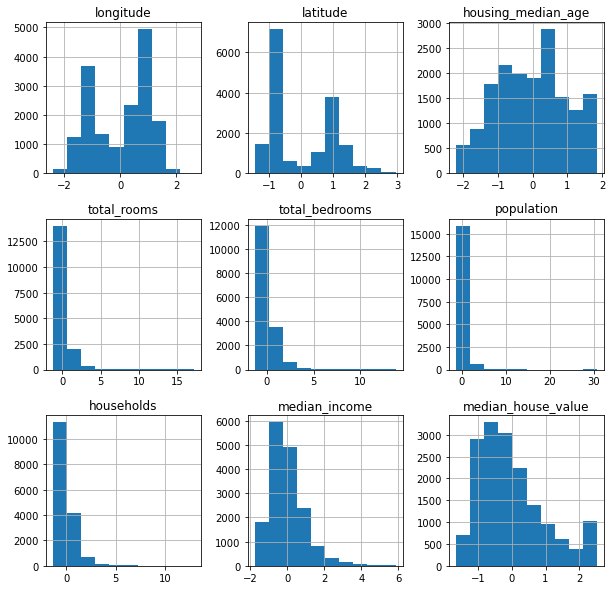

In [8]:
"""
Feature Scaling

We will employ a standardized scaling approach to the data, since many of our attributes
have long positive tails (i.e. many positive outliers)
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit the scaler to the data (finds mean and variance)
scaler.fit(housing_train_num)

# print calculated values for each column
print("calculated mean values:",scaler.mean_)
print("calculated variances:",scaler.var_)

# show new distributions
housing_scaled = pd.DataFrame(scaler.transform(housing_train_num),columns=num_attribs)
housing_scaled.hist(figsize=(10,10))

In [9]:
"""
Encoding Categorical Data

We will encode our ocean_proximity text data to be numerical
Since there are only 5 categories, and they are not necessarily "adjacent" to one another in the way integers
are, we will use one-hot encoding.
This will convert our 1 categorical variable into 5 boolean variables. Each data entry will have a value of 1
for one of the resulting columns, and 0 for all others.
"""
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

# fit the encoder to the data and transform the data at the same time, using fit_transform
housing_cat_1hot = cat_encoder.fit_transform(housing_train_cat)

# this should return a sparse array
print(housing_cat_1hot[:10])
print(cat_encoder.categories_)

# save one-hot column labels for later
onehot_cols = list(cat_encoder.categories_[0])

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


# Putting it all together 
using a scikit-learn pipeline, we will combine and automate all the preprocessing steps that we have designed so far.  
1. create new attributes (rooms per household, bedrooms per room, population per household)
2. replace missing values with the median statistic for that column
3. scale all numerical data with standardized scales
4. encode the ocean_proximity categorical variable using the one-hot method

In [20]:
# create a pipeline for our numerical attributes only
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [11]:
# combine the numerical pipeline with the categorical one (just one-hot encoding)
from sklearn.compose import ColumnTransformer

# ColumnTransformer needs lists of the indices that each pipeline applies to
num_cols = list(range(0,9))
cat_cols = [9]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

In [12]:
# lets test the full pipeline

# put all the column labels together
cols = num_attribs + combined_cols + onehot_cols

# run the pipeline, and store the result in a DataFrame
housing_train_prepared = pd.DataFrame(full_pipeline.fit_transform(housing_train),columns=cols)

In [19]:
print(cols)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


In [13]:
housing_train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   rooms_per_household       16512 non-null  float64
 10  bedrooms_per_room         16512 non-null  float64
 11  population_per_household  16512 non-null  float64
 12  <1H OCEAN                 16512 non-null  float64
 13  INLAND                    16512 non-null  float64
 14  ISLAND

In [14]:
housing_train_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,0.688068,-0.312055,0.155318,-0.086499,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.154794,0.217683,-0.836289,-0.033534,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.087217,-0.465315,0.422200,-0.092405,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-1.388864,-0.079661,-0.196453,0.089736,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,0.410625,-0.357834,0.269928,-0.004194,1.0,0.0,0.0,0.0,0.0


In [15]:
housing_train_prepared.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-4.353107e-15,2.284564e-15,-4.701235e-17,7.587062e-17,1.360615e-16,-3.700743e-17,2.078979e-17,-2.102108e-16,-5.551115e-17,8.014691e-17,-4.878742e-17,-1.621765e-17,0.440649,0.318738,0.000121,0.111858,0.128634
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,0.496480,0.466001,0.011005,0.315201,0.334804
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00,-1.659401e+00,-1.650273e+00,-2.704542e+00,-2.075303e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01,-7.535980e-01,-3.822514e-01,-5.914834e-01,-5.741738e-02,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01,-2.376062e-01,-7.966522e-02,-1.628895e-01,-2.406537e-02,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01,4.918697e-01,2.358755e-01,4.044268e-01,1.596812e-02,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00,2.532509e+00,5.225419e+01,3.975916e+01,1.070603e+02,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>],
       [<AxesSubplot:title={'center':'rooms_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>]],
      dtype=object)

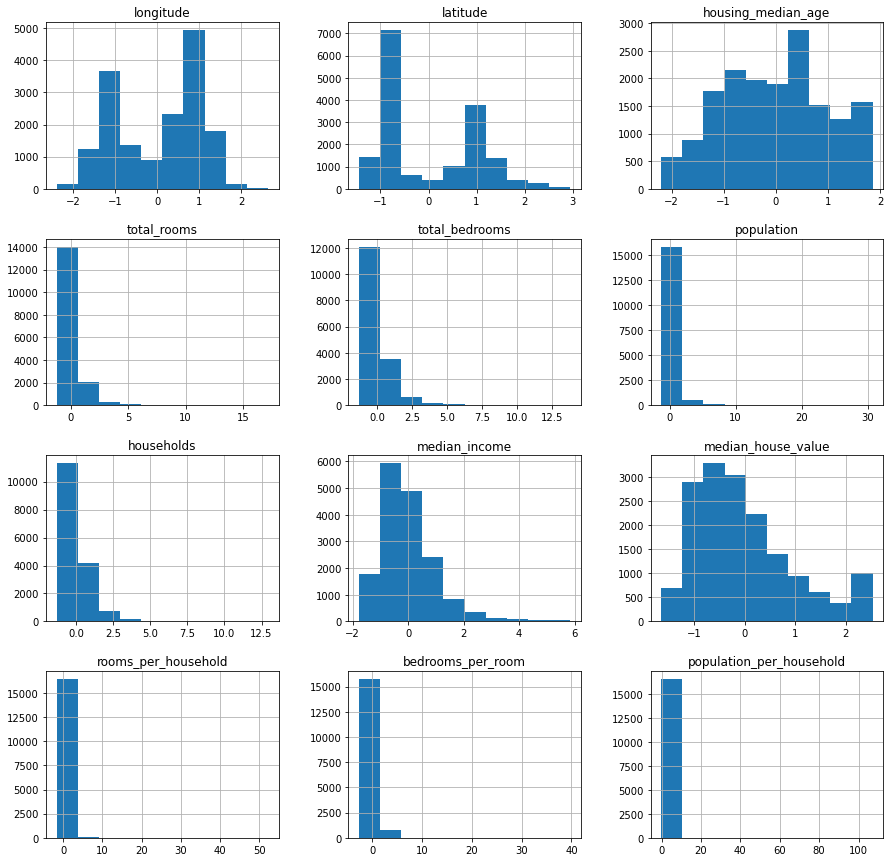

In [16]:
housing_train_prepared.drop(columns=onehot_cols,axis=1).hist(figsize=(15,15))

Our code for the full data cleaning pipeline w